In [11]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import mef_test, functions

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from bokeh.plotting import figure, output_file, show
pd.set_option('display.max_columns', 500)
params = {'legend.fontsize': 'large',
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':20,
         'ytick.labelsize':24}
plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Reading in our data in the same way as my previous notebook

In [12]:
X_raw = pd.read_csv('../data/train_data.csv', dtype={'id': object})
y_raw = pd.read_csv('../data/train_targets.csv', dtype={'id': object})

# Join the two tables using their 'id' column
df = y_raw.set_index('id').join(X_raw.set_index('id'))

# Rates of functionality differ across regions
Various studies have found that regional and geographic factors play a huge role in well fucntionality. This could be due to proximity to spare part suppliers, the competency of local government maintenance programs, or the strains that geographic restrictions may place on well design. The difference between the region with the most functional wells and the region with the least is significant: 80% of wells in the Iringa region are functioning, compared to 35% of wells in the Lindi region

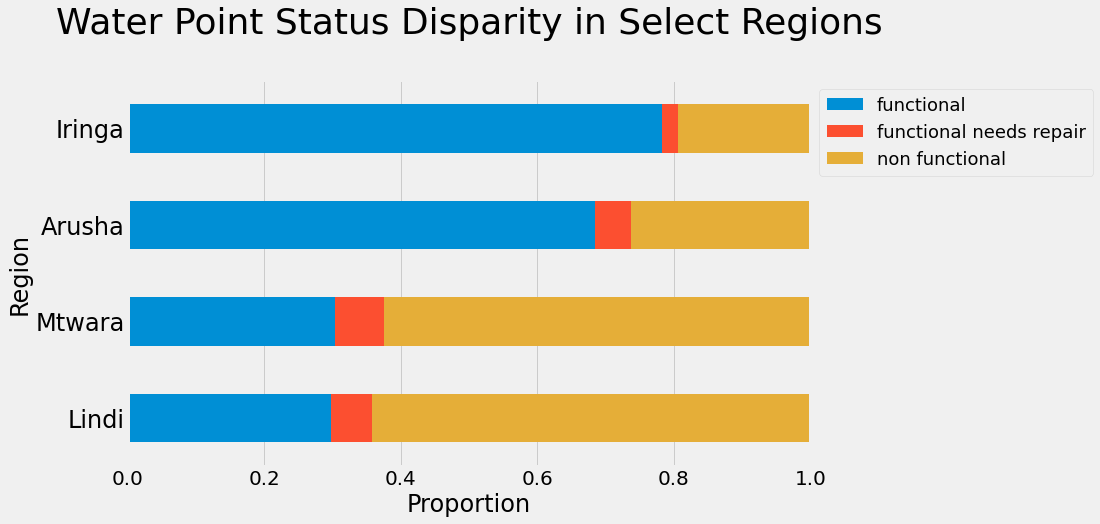

In [17]:
# I think this would be more useful as an unstacked DataFrame
reg = df.groupby('region')['status_group'].value_counts().unstack()

# Making some new columns...i know this is not the most efficient way to do this
reg['pfunc'] = reg['functional'] / (reg['functional']
                                    + reg['functional needs repair']
                                    + reg['non functional'])
reg['prep'] = reg['functional needs repair'] / (reg['functional']
                                    + reg['functional needs repair']
                                    + reg['non functional'])
reg['pnon'] = reg['non functional'] / (reg['functional']
                                    + reg['functional needs repair']
                                    + reg['non functional'])

# Going to get just the 2 regions with the highest proportion of functional water points, and then the 2 regions with the lowest
ratios = reg.drop(['functional', 'functional needs repair', 'non functional'], axis=1)
rename = {'pfunc':'functional','prep':'functional needs repair' , 'pnon':'non functional'}
ratios.rename(columns=rename, inplace=True)

sortedx = ratios.sort_values('functional')
extreme = pd.concat([sortedx.head(2), sortedx.tail(2)])

# Now I'll plot these 4 regions as a segmented bar plot

plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(18,10))
ax.set_title('Water Point Status Disparity in Select Regions\n',
             fontdict={'fontsize':36})

ax.set_xlabel('Proportion')
ax.set_xlim(0,1)
extreme.plot.barh(stacked=True, ax=ax);
ax.set_ylabel('Region',)
ax.legend(fontsize=18, bbox_to_anchor=(1,1));
plt.tight_layout(pad=7)

# Rate of functionality by decade
Naturally We would explore the relationship between the level of functioning wells and how old that well is. In the graph below, we group all wells into 6 decades based on the year they were constructed. Here we see that rate of functionality is higher if it is built more recently.

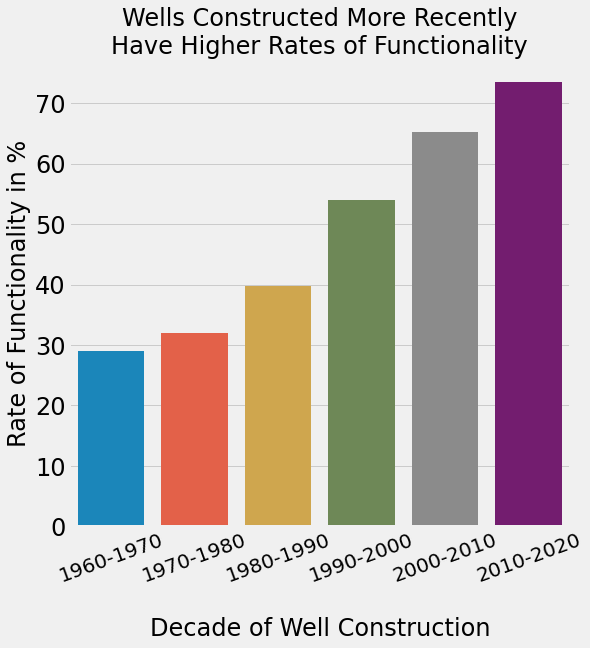

In [18]:
df['outcome_binary'] = mef_test.make_binary(df, 'status_group', 'functional')

no_zeros = df[df['construction_year']!=0].copy()

no_zeros['decade'] = no_zeros['construction_year'].map(functions.bin_year)


functionality_by_year = no_zeros.groupby('decade').outcome_binary.mean()

fig, ax = plt.subplots(1,1, figsize=(8,8))


sns.barplot(functionality_by_year.index, functionality_by_year.values*100)
ax.set_xlabel("\nDecade of Well Construction")
ax.set_ylabel("Rate of Functionality in %")
plt.xticks(rotation=20)


ax.set_title("Wells Constructed More Recently\nHave Higher Rates of Functionality");




# Rate of Functionality differences for Government built wells

Across Tanzania, wells have been installed by a variety of organizations. In addition to government efforts to increase water supply, various NGOs and foreign government agencies have provided assistance in installing well infrastructure. There may be drastic differences between installation quality between these groups. We can find this effect when we look at the distributions of each functionality group and compare it to the rates of fucntionality for all wells. In the graph below, we look at the total functionality rates for all wells across tanzania and we compare it to a subset of wells that we're recorded as having been installed by the government.

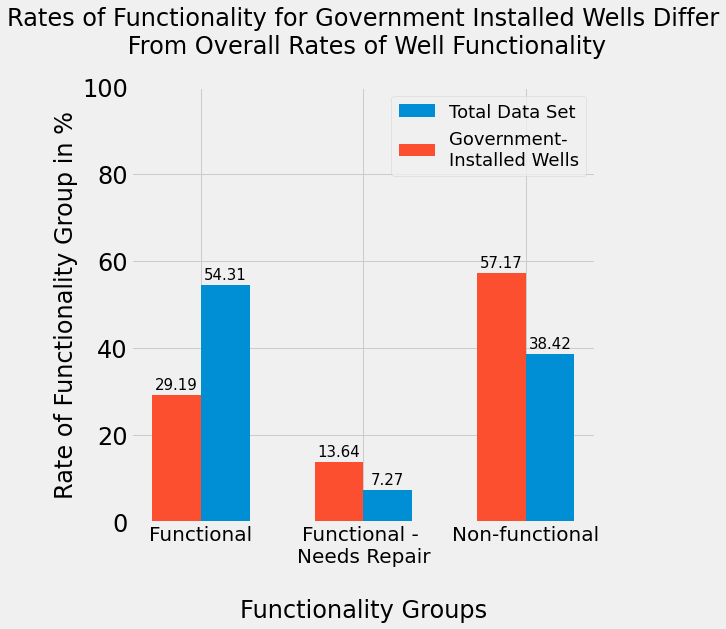

In [19]:
df['installer'] = df['installer'].fillna('unknown')

df['installer'] = df['installer'].map(lambda x: x.lower())

df.installer.value_counts()

dataframe = df
possible_values = list(dataframe['installer'].unique())
column = 'installer'

fig, ax = plt.subplots(1, 1, figsize=(9,9))
labels = ['Functional', 'Functional - \nNeeds Repair', 'Non-functional']
data_set_prcnts = mef_test.calc_prcnts(dataframe)
subset_percents = mef_test.calc_prcnts(dataframe, col_name=column, value='government')

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars


rects1 = ax.bar(x + width/2, data_set_prcnts, width, label='Total Data Set', align='center')
rects2 = ax.bar(x - width/2, subset_percents, width, label='Government-\nInstalled Wells', align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('\nFunctionality Groups')
ax.set_ylabel('Rate of Functionality Group in %')
ax.set_title(f'Rates of Functionality for Government Installed Wells Differ\n From Overall Rates of Well Functionality\n')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0,100)


mef_test.autolabel(rects1, ax)
mef_test.autolabel(rects2, ax)


fig.tight_layout()

plt.show();